In [1]:
import os, sys, collections

if not os.path.exists('ILSVRC_data'):
    
    !tar -xf ILSVRC_data.tar

if not os.path.exists('models'):
    
    !git clone https://github.com/tensorflow/models/

if not os.path.isfile('InceptionModel/inception_v4.ckpt'):
    
    !wget -P InceptionModel http://download.tensorflow.org/models/inception_v4_2016_09_09.tar.gz
    !tar -xf InceptionModel/inception_v4_2016_09_09.tar.gz -C InceptionModel
    !rm InceptionModel/inception_v4_2016_09_09.tar.gz

sys.path.append(os.path.abspath('models/research/slim'))

from scipy.misc import imread
from nets import inception_v4

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image

from deepexplain.tensorflow import DeepExplain
from utils import preprocess, pixel_range

slim = tf.contrib.slim

checkpoint = 'InceptionModel/inception_v4.ckpt'

In [2]:
def load_images(img_dir, img_size=(299,299)):
    
    def file_number(x):
        
        return int(x.split('.')[0])

    filenames = sorted(os.listdir(img_dir), key=file_number)
    filenames_valid = []
    images = []
    
    for file in filenames:
        
        try:
            
            image = PIL.Image.open(img_dir + file)
            image = np.array(image.resize(img_size, PIL.Image.ANTIALIAS))
            
            if image.ndim < 3 or (image.ndim == 3 and image.shape[-1] != 3):
                
                raise Exception('Invalid Image')
            
            images.append(image)
            filenames_valid.append(file)
            
        except:
            
            continue
    
    images = [image for image in images if len(image.shape) == 3]
    images = np.array(images)
    images = images / 127.5 - 1.0
    
    return filenames_valid, images

LABELS_LOC='InceptionModel/imagenet_comp_graph_label_strings.txt'
label_map = np.array(open(LABELS_LOC).read().split('\n'))

### Attribution Map Generation

In [3]:
tf.reset_default_graph()
sess = tf.Session()

with DeepExplain(session=sess, graph=sess.graph) as de:
    
    X = tf.placeholder(tf.float32, shape=(None, 299, 299, 3))

    with slim.arg_scope(inception_v4.inception_v4_arg_scope()):
        _, end_points = inception_v4.inception_v4(X, num_classes=1001, is_training=False)

    logits = end_points['Logits']
    yv = tf.reduce_max(logits, 1)
    yi = tf.argmax(logits, 1)

    saver = tf.train.Saver(slim.get_model_variables())
    saver.restore(sess, checkpoint)
    
    filenames, xs = load_images('ILSVRC_data/interclass/')
    # filenames, xs = load_iamges('ILSVRC_data/intraclass/')
    labels = sess.run(yi, feed_dict={X: xs})

    attribution_methods = [
                           ('RectGrad'         , 'rectgrad'),
                           ('RectGrad PRR'     , 'rectgradprr'),
                           ('Saliency Map'     , 'saliency'),
                           ('Guided BP'        , 'guidedbp'),
                           ('SmoothGrad'       , 'smoothgrad'),
                           ('Gradient * Input' , 'grad*input'),
                           ('IntegGrad'        , 'intgrad'),
                           ('Epsilon-LRP'      , 'elrp'),
                           ('DeepLIFT'         , 'deeplift')
                          ]

    attribution_methods = collections.OrderedDict(attribution_methods)
    
    attributions_orig   = collections.OrderedDict()
    attributions_sparse = collections.OrderedDict()
    
    for k, v in attribution_methods.items():
        
        print('Running {} explanation method'.format(k))
        
        attribution = de.explain(v, yv, X, xs)
        
        if 'RectGrad' in k:
            attributions_orig[k]   = preprocess(attribution, 0.5, 99.5)
            attributions_sparse[k] = preprocess(attribution, 0.5, 99.5)
        else:
            attributions_orig[k]   = preprocess(attribution, 0.5, 99.5)
            attributions_sparse[k] = preprocess(attribution, 95, 99.5)
    
    print('Done!')

INFO:tensorflow:Restoring parameters from InceptionModel/inception_v4.ckpt
Running RectGrad explanation method
Running RectGrad PRR explanation method
Running Saliency Map explanation method
Running Guided BP explanation method
Running SmoothGrad explanation method
Running Gradient * Input explanation method
Running IntegGrad explanation method
Running Epsilon-LRP explanation method
Running DeepLIFT explanation method
Done!


### Attribution Map Comparison W/O Baseline Final Thresholding

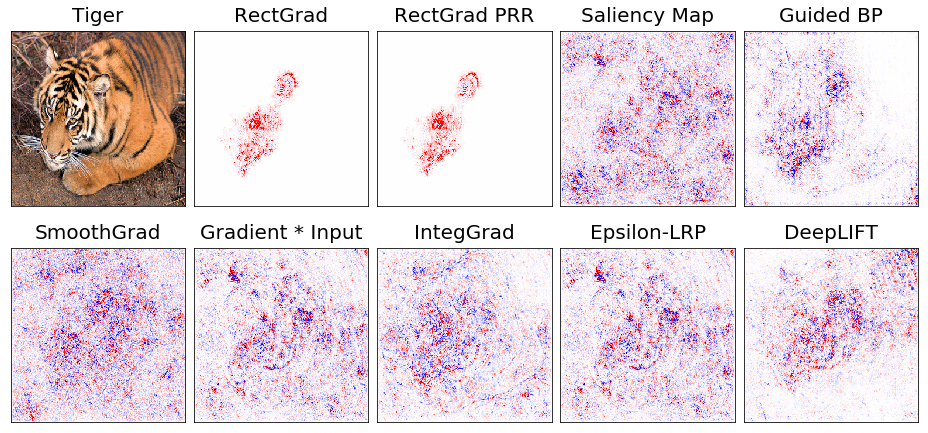

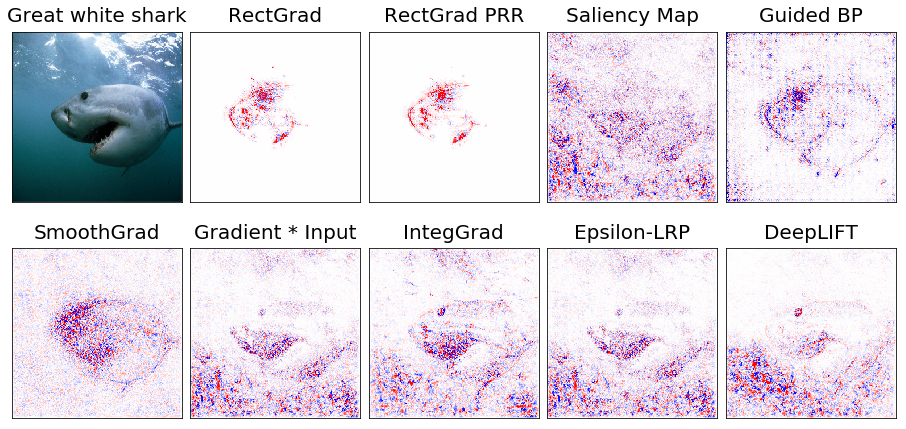

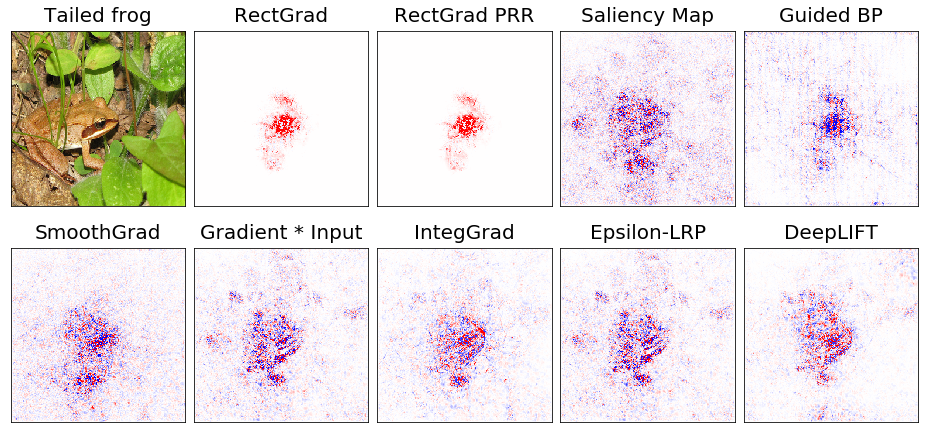

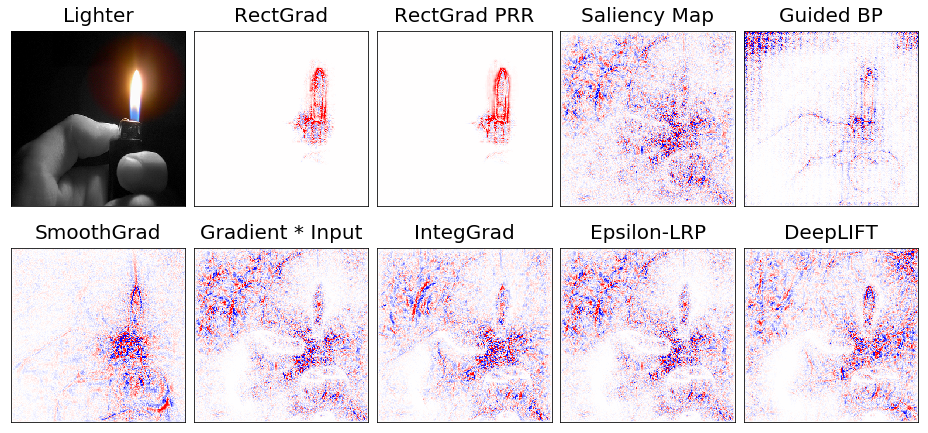

In [4]:
for i, xi in enumerate(xs):
    
    plt.figure(figsize=(13,6))
    
    xi = (xi - np.min(xi))
    xi /= np.max(xi)
    
    plt.subplot(2, 5, 1)
    plt.imshow(xi)
    plt.xticks([])
    plt.yticks([])
    plt.title(label_map[labels[i] - 1].split(',')[0].capitalize(), fontsize=20, pad=10)
    
    for j, a in enumerate(attribution_methods):
        
        plt.subplot(2, 5, j + 2)
        v, cmap = pixel_range(attributions_orig[a][i])
        plt.imshow(attributions_orig[a][i], vmin=v[0], vmax=v[1], cmap=cmap)
        plt.xticks([])
        plt.yticks([])
        plt.title(a, fontsize=20, pad=10)
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05, hspace=0.2)
    plt.show()    
    
    plt.close()

### Attribution Map Comparison with Baseline Final Thresholding

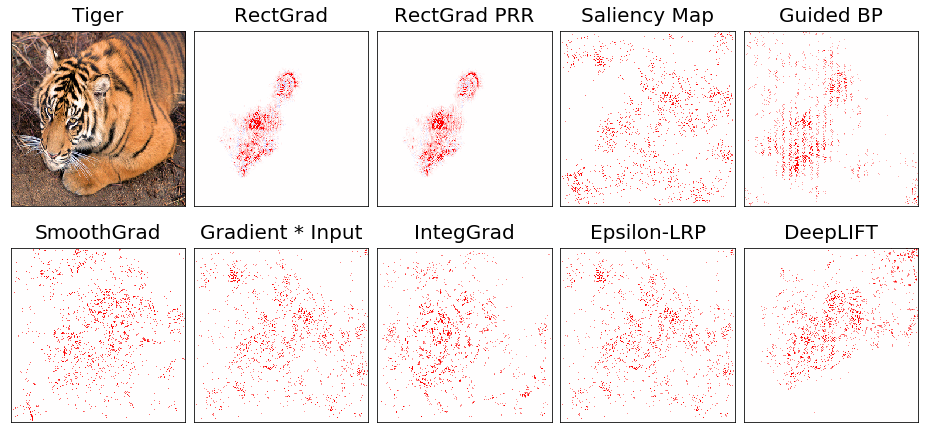

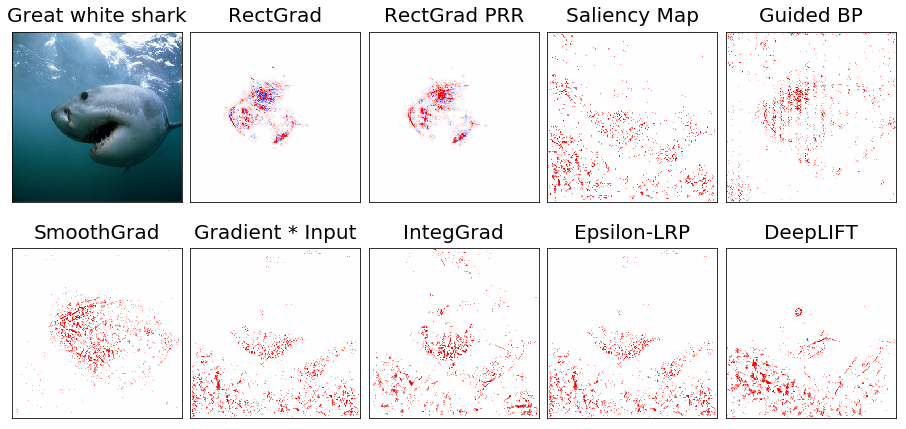

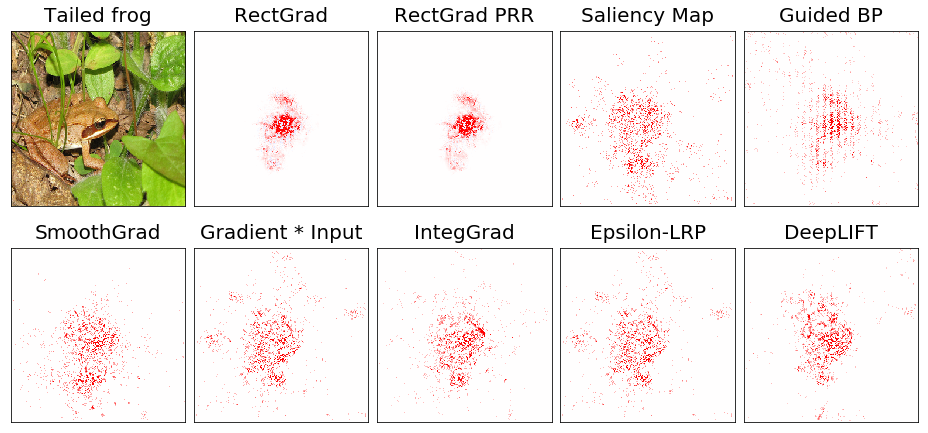

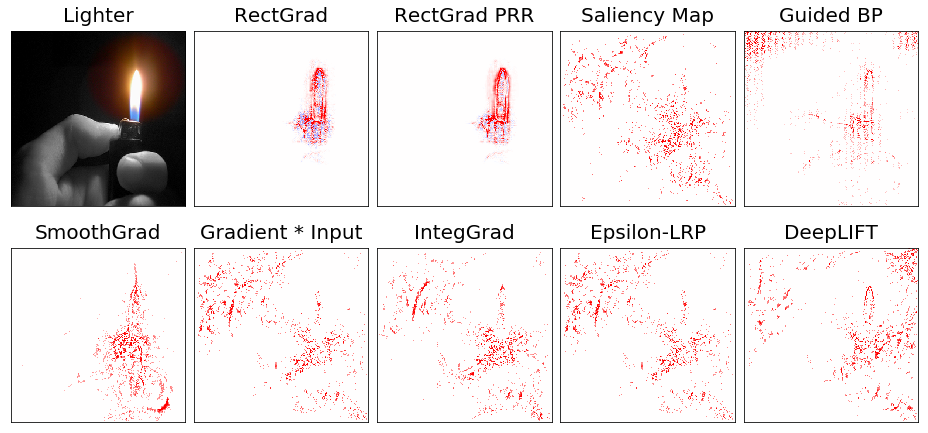

In [5]:
for i, xi in enumerate(xs):
    
    plt.figure(figsize=(13,6))
    
    xi = (xi - np.min(xi))
    xi /= np.max(xi)
    
    plt.subplot(2, 5, 1)
    plt.imshow(xi)
    plt.xticks([])
    plt.yticks([])
    plt.title(label_map[labels[i] - 1].split(',')[0].capitalize(), fontsize=20, pad=10)
    
    for j, a in enumerate(attribution_methods):
        
        plt.subplot(2, 5, j + 2)
        v, cmap = pixel_range(attributions_sparse[a][i])
        plt.imshow(attributions_sparse[a][i], vmin=v[0], vmax=v[1], cmap=cmap)
        plt.xticks([])
        plt.yticks([])
        plt.title(a, fontsize=20, pad=10)
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05, hspace=0.2)
    plt.show()    
    
    plt.close()